# Diffusion Illusions: The Parker Puzzle Demo

Hi! Welcome to the official colab demo for our demo "Diffusion Illusions: Hiding Images in Plain Sight"

By Ryan Burgert, Xiang Li, Abraham Leite, Kanchana Ranasinghe and Michael Ryoo from Stony Brook University

Visit our project website: [diffusionillusions.com](https://ryanndagreat.github.io/Diffusion-Illusions/)

This project was inspired by our paper "Peekaboo: Text to Image Diffusion Models are Zero-Shot Segmentors". The Peekaboo project website: [https://ryanndagreat.github.io/peekaboo/](https://ryanndagreat.github.io/peekaboo/)

Instructions:

0. Go to the Runtime menu, and make sure this notebook is using GPU!
1. Run the top 2 code cells (one cleans colab's junk and downloads the source code, while the other installs python packages)
2. Click 'Runtime', then 'Restart Runtime'. You need to do this the first time you open this notebook to avoid weird random errors from the pip installations.
3. Run code cells to load stable diffusion. The first time you run it it will take a few minutes to download; subsequent times won't take long at all though.
4. Run all the cells below that, and customize prompt_a and prompt_b!
5. Take the result top_image and bottom_image, print them out, and shine a backlight through them like shown in the Diffusion Illusion website (link above!)

I may also create a YouTube tutorial if there's interest. Let me know if this would be helpful!

This notebook was written by Ryan Burgert. Feel free to reach out to me at rburgert@cs.stonybrook.edu if you have any questions! 

In [ ]:
%%bash
if [ ! -d ".git" ]; then 
    rm -rf * .*; #Get rid of Colab's default junk files
    git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .
fi

In [ ]:
%pip install --upgrade -r requirements.txt
%pip install rp --upgrade
# You may need to restart the runtime after installing these
# I'm not sure why this helps, but all sorts of weird random errors pop up in Colab if you don't

In [1]:
#SET YOUR PROMPTS HERE

prompt_a = "A ceramic coffee mug with handle viewed from side and steam rising. Beautiful 4k photography unreal engine 3d "
prompt_b = "A donut. A shiny frosted chocolate donut. Beautiful 4k photography unreal engine 3d"


#Optional: Specify what you DON'T want to see
negative_prompt = 'blurry ugly'

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up
print('    prompt_b =', repr(prompt_b)) #This will be upside-down


Negative prompt: 'blurry ugly'

Chosen prompts:
    prompt_a = 'A ceramic coffee mug with handle viewed from side and steam rising. Beautiful 4k photography unreal engine 3d '
    prompt_b = 'A donut. A shiny frosted chocolate donut. Beautiful 4k photography unreal engine 3d'


In [2]:
from rp import *
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

/home/ryan/miniconda3/envs/diffilu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.12.1 with CUDA 1106 (you have 2.2.1+cu118)
    Python  3.10.13 (you have 3.10.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [3]:
if 's' not in dir():
    #You can select the original Stable Diffusion 1.5 or some dreambooth of it
    model_name="CompVis/stable-diffusion-v1-4"
    model_name="runwayml/stable-diffusion-v1-5"
    # model_name="nitrosocke/Arcane-Diffusion"
    gpu=rp.select_torch_device()
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

Couldn't connect to the Hub: 404 Client Error. (Request ID: Root=1-66ea91ba-2eeefad0389128377564e9ac;7be11abb-4065-4e1d-bbac-56c268fff6b6)

Repository Not Found for url: https://huggingface.co/api/models/runwayml/stable-diffusion-v1-5.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated..
Will try to load from local cache.


                      ┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
                      ┃ GPU ID ┃       Name       ┃      Used      ┃   Free ┃  Total ┃ Temp ┃ Util ┃ Processes                          ┃
                      ┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
                      │   0    │ NVIDIA RTX A5000 │  12.3GB  51.5% │ 11.6GB │ 24.0GB │ 35°C │   0% │ ryan 11.1GB: 1704144 11.1GB;       │
                      │        │                  │                │        │        │      │      │ yjang43 922MB: 2984475 922MB       │
Selecting cuda:1 –––> │   1    │ NVIDIA RTX A5000 │ 322.2MB   1.3% │ 23.7GB │ 24.0GB │ 63°C │   0% │                                    │
                      │   2    │ NVIDIA RTX A5000 │ 322.2MB   1.3% │ 23.7GB │ 24.0GB │ 48°C │   0% │                                    │
                      │   3    │ N

Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.90it/s]


[INFO] sd.py: loaded stable diffusion!


In [4]:
label_a = NegativeLabel(prompt_a,negative_prompt)
label_b = NegativeLabel(prompt_b,negative_prompt)

In [5]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256,width=256,num_features=256,hidden_dim=256,scale=10).to(s.device);SIZE=256

image=learnable_image_maker()

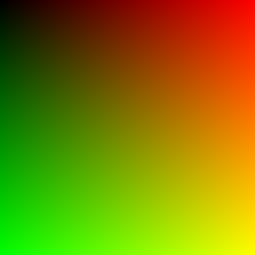

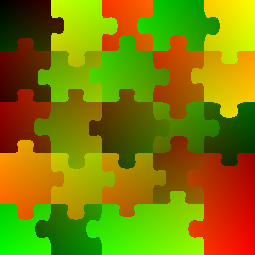

In [6]:
import torch
import torch.nn.functional as F

#This is the puzzle Matt used in his video!
uv_map_b = rp.load_image("https://github.com/RyannDaGreat/Images/blob/master/test_images/parker_puzzle_uv_map.png?raw=true")
uv_map_a = rp.get_identity_uv_map(*rp.get_image_dimensions(uv_map_b))

rp.display_image(uv_map_a)
rp.display_image(uv_map_b)

learnable_image_a = lambda: rp.apply_uv_map(image(), uv_map_a)
learnable_image_b = lambda: rp.apply_uv_map(image(), uv_map_b)

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [7]:
labels=[label_a,label_b]
learnable_images=[learnable_image_a,learnable_image_b]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [8]:
#For saving a timelapse
ims=[]

In [9]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
            rp.as_numpy_image(learnable_image_b()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

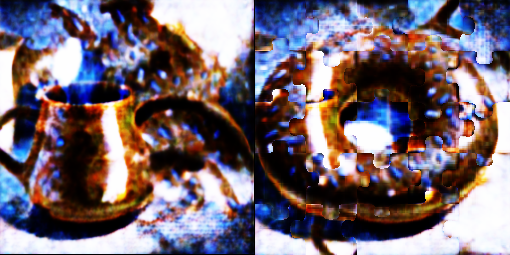

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


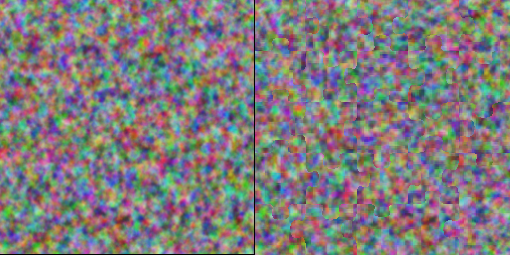

Status: ETR=0:25:54.660158	ETA=0:26:59.437665	T=0:01:04.777507	Progress: 200/5000

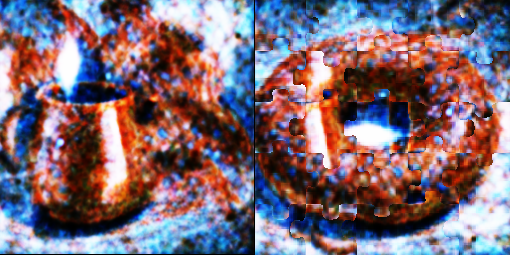

Status: ETR=0:25:01.568220	ETA=0:27:12.139370	T=0:02:10.571150	Progress: 400/5000

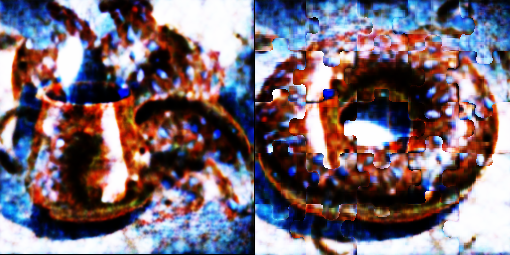

Status: ETR=0:24:01.047235	ETA=0:27:17.553676	T=0:03:16.506441	Progress: 600/5000

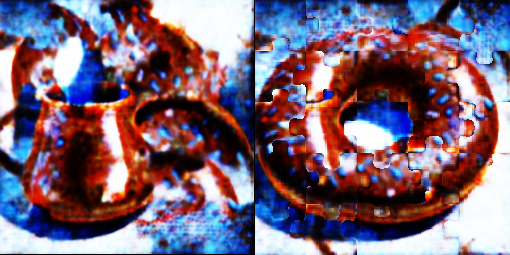

Status: ETR=0:23:30.041194	ETA=0:27:19.964171	T=0:03:49.922977	Progress: 701/5000
Interrupted early at iteration 701


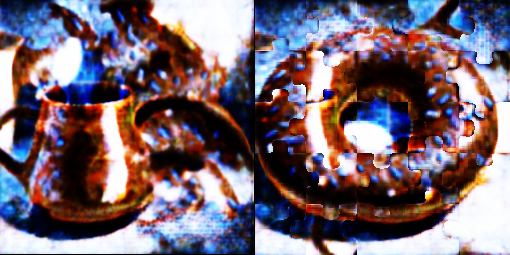

In [10]:
NUM_ITER=5000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

television = rp.JupyterDisplayChannel()
television.display()

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=100,#10
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%(DISPLAY_INTERVAL//4):
                im = get_display_image()
                ims.append(im)
                television.update(im)
                
                if not iter_num%DISPLAY_INTERVAL:
                    rp.display_image(im)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

Unsolved Image:


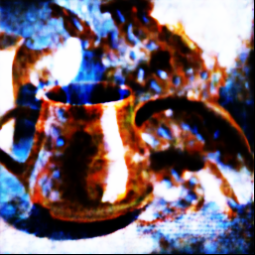

Solved Image:


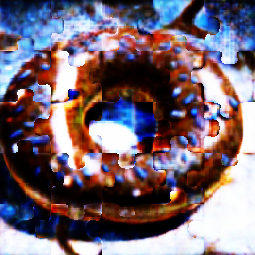

In [13]:
print('Unsolved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

print('Solved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_b()))

In [12]:
def save_run(name):
    folder="untracked/parker_puzzle_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('-'.join([prompt_a,prompt_b])) #You can give it a good custom name if you want!

Saving Images: ETR=0:00:00.565476	ETA=0:00:01.292516	T=0:00:00.727041	Progress: 9/16rp.save_images: Done! Saved 16 images in 0.987 seconds

Saved timelapse to folder: 'untracked/parker_puzzle_runs/A ceramic coffee mug with handle viewed from side and steam rising. Beautiful 4k photography unreal engine 3d -A donut. A shiny frosted chocolate donut. Beautiful 4k photography unreal engine 3d_1726648994'
